I initially had a hard time understanding the tensor dimensions defining the conv layers in PyTorch.

# Task 1

Number of samples: 50000
Image shape: (32, 32)
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label: 6 (frog)


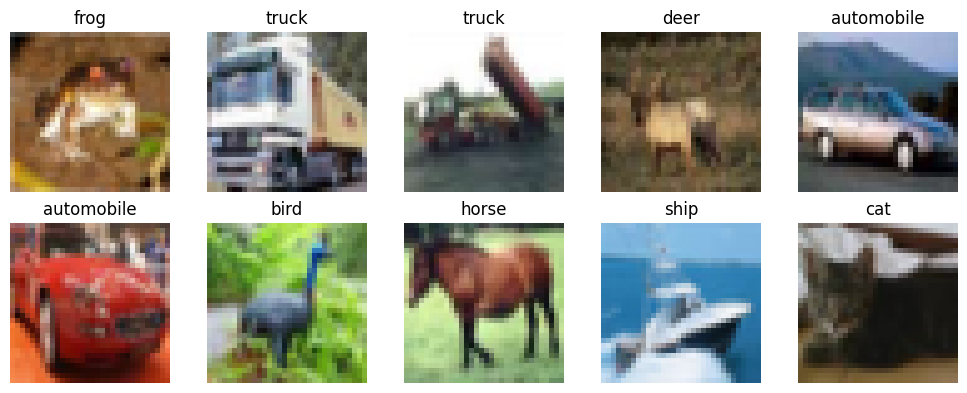

In [3]:
import torchvision
# torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

import matplotlib.pyplot as plt

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)

# Basic info
print(f"Number of samples: {len(trainset)}")
print(f"Image shape: {trainset[0][0].size}")  # PIL Image size (width, height)
print(f"Number of classes: {len(trainset.classes)}")
print(f"Classes: {trainset.classes}")

# Look at a single sample
image, label = trainset[0]
print(f"Label: {label} ({trainset.classes[label]})")

# Display some images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img, lbl = trainset[i]
    ax.imshow(img)
    ax.set_title(trainset.classes[lbl])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN_task1(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial size progression: 32 -> 16 -> 8 -> 4
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)    # (3, 32, 32) -> (64, 32, 32)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (64, 16, 16) -> (128, 16, 16)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (128, 8, 8) -> (256, 8, 8)
        self.pool = nn.MaxPool2d(2, 2)  # Halves spatial dimensions
        self.fc1 = nn.Linear(256 * 4 * 4, 10)  # 256 channels * 4 * 4 spatial

    def forward(self, x):
        # Block 1: 32 -> 16
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Block 2: 16 -> 8
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Block 3: 8 -> 4
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = CNN_task1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transforms: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from tqdm import tqdm

def train(model, num_epochs=10, lr=1e-3):
    """Train a model on CIFAR-10."""
    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")
    
    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track stats
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{running_loss/total:.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })
        
        print(f"Epoch {epoch+1} complete - Loss: {running_loss/len(trainloader):.4f}, Acc: {100.*correct/total:.2f}%")
    
    return model

In [6]:
# Train the model
model = CNN_task1()
model = train(model, num_epochs=1)

Training on: cpu


Epoch 1/1: 100%|██████████| 782/782 [00:49<00:00, 15.76it/s, loss=0.0203, acc=53.57%]

Epoch 1 complete - Loss: 1.2966, Acc: 53.57%
